In [2]:
!pip install pytorch_lightning
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch
import torch.nn as nn
from torchmetrics import PearsonCorrCoef, MeanSquaredError
!pip install colorama
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
import scprep

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.decomposition import TruncatedSVD

!pip install tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.utils import plot_model

%cd /home/jovyan/kaggle/working

%cd robust-pca
import r_pca
%cd ..

def delete_columns_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:,mask]

def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def correlation_score_cols(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    abc = []
    for i in range(y_true.shape[1]):
        temp = np.corrcoef(y_true[:,i], y_pred[:,i])[1, 0]
        abc.append(temp)
        corrsum += temp
    print(corrsum / y_true.shape[1])
    return abc

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def negative_pearson_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    vx = y_pred - torch.mean(y_pred,1,keepdim=True)
    vy = y_true - torch.mean(y_true,1,keepdim=True)

    cost = torch.mean(torch.sum(vx * vy,1) / (torch.sqrt(torch.sum(vx ** 2,1)) * torch.sqrt(torch.sum(vy ** 2,1))))

    return - cost

def my_model(n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x1 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x2 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x3 = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# Cross-validation
VERBOSE = 2 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr

        # We validate the model
        y_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(y_va, y_pred)

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)

        return model

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.1/796.1 kB 12.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.4/136.4 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115926 sha256=3bacda356488d02747d25bdc97a195af0494d78288930c1e53daac7311988e76
  Stored in directory: /home/jovyan/.cache/pip/wheels/2a/93/86/8cd17bc6c40fb605c3ac549d0b860ef7e84ee5f67bf01a3287
Successfully built fire


2022-11-02 23:34:45.767112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 23:34:46.233937: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-02 23:34:46.357036: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 23:34:47.641663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

/home/jovyan/kaggle/working
/home/jovyan/kaggle/working/robust-pca
/home/jovyan/kaggle/working


In [2]:
train = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")
test = scipy.sparse.load_npz("./sparse/test_multi_inputs_values.sparse.npz")

In [3]:
train.shape

(105942, 228942)

In [4]:
test.shape

(55935, 228942)

In [3]:
inputs_both_128 = np.genfromtxt("./multi_pca/inputs_both_128.csv", delimiter=',')

In [4]:
inputs_both_128.shape

(161877, 128)

In [5]:
multi_X_train = inputs_both_128[:105942]
multi_X_test = inputs_both_128[105942:]

In [8]:
multi_X_train.shape

(105942, 128)

In [9]:
multi_X_test.shape

(55935, 128)

In [373]:
multi_y_train = np.genfromtxt("./multi_pca/targets_128.csv", delimiter=',')

In [374]:
means = multi_y_train.mean(axis=1).reshape(-1, 1)
stds = multi_y_train.std(axis=1).reshape(-1, 1)

(array([1.2700e+02, 2.1990e+03, 8.7520e+03, 2.1268e+04, 3.3267e+04,
        2.6193e+04, 1.1215e+04, 2.5930e+03, 3.0200e+02, 2.6000e+01]),
 array([-0.7495836 , -0.20851865,  0.3325463 ,  0.87361126,  1.41467621,
         1.95574117,  2.49680612,  3.03787107,  3.57893603,  4.12000098,
         4.66106594]),
 <BarContainer object of 10 artists>)

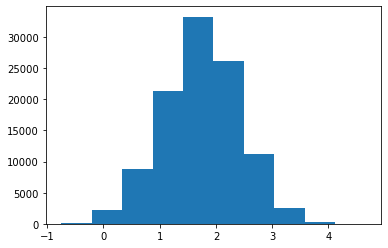

In [41]:
import matplotlib.pyplot as plt
plt.hist(means)

(array([  239.,  2221.,  6827., 14923., 24975., 27148., 18822.,  8088.,
         2410.,   289.]),
 array([10.71454845, 12.71276378, 14.7109791 , 16.70919442, 18.70740974,
        20.70562506, 22.70384038, 24.7020557 , 26.70027102, 28.69848634,
        30.69670166]),
 <BarContainer object of 10 artists>)

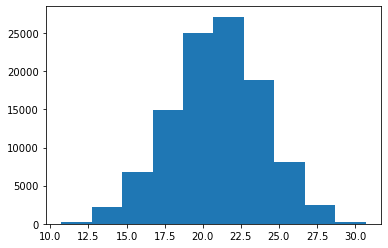

In [42]:
plt.hist(stds)

In [375]:
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
multi_y_train -= multi_y_train.mean(axis=1).reshape(-1, 1)
multi_y_train /= multi_y_train.std(axis=1).reshape(-1, 1)

In [6]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=128, random_state=1)
pca_targets = pca_train.fit_transform(targets)

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [378]:
%mkdir model_multi

In [ ]:
# from tensorflow.keras.layers import Dropout, BatchNormalization
# plateau = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss",
#     factor=0.5,
#     patience=2,
#     verbose=0,
#     mode="min",
#     min_delta=1e-7
# )
# es = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=1e-7,
#     patience=10,
#     verbose=0,
#     mode="min",
#     restore_best_weights=True,
# )

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']

with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)

with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

meta_t = metadata_df.reindex(cell_index_t)

VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 6

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = KFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(best_hp, n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr
        if True:
            model.save(f"./model_multi/model_{fold}")

        history = history.history
        callbacks, lr = None, None

        # We validate the model
        y_va_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(targets[idx_va], pca_train.inverse_transform(y_va_pred))

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)
    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

fit(multi_X_train,pca_targets,meta)

In [21]:
multi_X_train

array([[ 3.86956635e+01, -1.09952993e+01,  3.50867796e+00, ...,
         1.21763420e+00, -1.44998670e+00,  1.60880759e-01],
       [ 3.06719627e+01, -1.19265258e+00, -4.12954807e+00, ...,
         1.85832608e+00, -7.65001774e-01, -1.92534491e-01],
       [ 3.70699081e+01, -3.83116531e+00,  4.17799902e+00, ...,
        -8.05579841e-01,  5.00358164e-01, -6.38681412e-01],
       ...,
       [ 4.48155479e+01, -9.39706898e+00,  6.36478782e-01, ...,
         1.58140473e-02, -1.86308980e-01, -6.92828357e-01],
       [ 3.59599037e+01,  1.49864283e+01, -1.74750173e+00, ...,
        -2.24051282e-01, -2.21296221e-01, -2.21505928e+00],
       [ 3.49002457e+01, -1.32985905e-01,  1.07605591e+01, ...,
        -1.89213276e-01, -1.23102295e+00, -3.50553632e-01]])

In [23]:
multi_y_pred = model.predict(multi_X_test)

1748/1748 [==============================] - 4s 2ms/step


In [39]:
multi_y_pred.shape

(55935, 128)

In [38]:
stds.shape

(105942, 1)

In [37]:
multi_y_pred *= stds

ValueError: operands could not be broadcast together with shapes (55935,128) (105942,1) (55935,128) 

In [9]:
%cd /home/jovyan/kaggle/working

targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")

/home/jovyan/kaggle/working


In [32]:
targets

<105942x23418 sparse matrix of type '<class 'numpy.float32'>'
	with 407024875 stored elements in Compressed Sparse Row format>

In [33]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
scprep.filter.remove_empty_genes(targets)

<105942x22858 sparse matrix of type '<class 'numpy.float32'>'
	with 407024875 stored elements in Compressed Sparse Row format>

Need to remember to add the zero genes back in at the end!

In [28]:
targets = scprep.filter.remove_empty_genes(targets)

# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=128, random_state=1)
targets = pca_train.fit_transform(targets)

%cd multi_pca

np.savetxt("targets_norm_128.csv", targets, delimiter=",")
np.savetxt("pca_for_targets_128.csv",pca_train,delimiter=",")

ValueError: n_components == 128, must be <= 76.

(array([  693.,  4423., 11703., 23173., 29348., 21664., 10258.,  3490.,
         1107.,    83.]),
 array([0.32211512, 0.43754733, 0.5529795 , 0.66841173, 0.78384393,
        0.89927614, 1.0147083 , 1.1301405 , 1.2455727 , 1.361005  ,
        1.4764371 ], dtype=float32),
 <BarContainer object of 10 artists>)

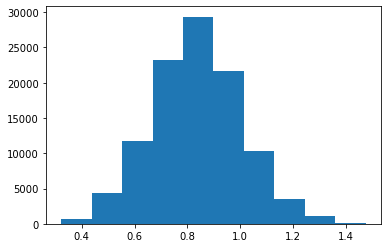

In [43]:
plt.hist(targets.mean(axis=1).reshape(-1, 1))

In [52]:
targets.shape[1]

23418

In [59]:
N = targets.shape[1]
sqr = targets.copy() 
sqr.data **= 2 # square the data, i.e. just the non-zero data
stds = np.sqrt(sqr.sum(axis=1)/N - targets.mean()**2)

In [60]:
stds.shape

(105942, 1)

(array([   72.,   716.,  2443.,  6370., 14116., 26007., 30569., 19227.,
         5722.,   700.]),
 array([1.1563938, 1.2811863, 1.4059789, 1.5307715, 1.6555641, 1.7803566,
        1.9051492, 2.0299418, 2.1547344, 2.279527 , 2.4043195],
       dtype=float32),
 <BarContainer object of 10 artists>)

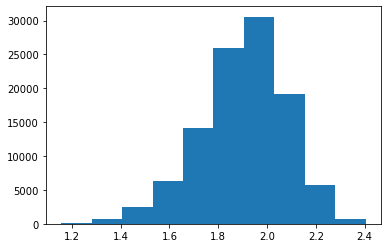

In [61]:
plt.hist(stds.reshape(-1, 1))

In [72]:
y_means = multi_y_train.mean(axis=1).reshape(-1, 1)

In [65]:
y_means

array([[1.36506398],
       [1.77104668],
       [0.80547902],
       ...,
       [0.81055583],
       [1.11209707],
       [0.23754894]])

In [73]:
mean_model = fit(multi_X_train,y_means,meta)

Epoch 1/1000
Batch 0: Invalid loss, terminating training
270/270 - 1s - loss: nan - negative_correlation_loss: nan - val_loss: nan - val_negative_correlation_loss: nan - lr: 0.0100 - 1s/epoch - 5ms/step
1/1 [==============================] - 0s 99ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Fold 0:   0 epochs, corr =  nan


In [68]:
y_means.shape

(105942, 1)

In [69]:
multi_X_train.shape

(105942, 128)

In [74]:
y_stds = multi_y_train.std(axis=1).reshape(-1, 1)

In [75]:
y_stats = np.hstack([y_means,y_stds])

In [89]:
y_stats

array([[ 1.36506398, 20.13082698],
       [ 1.77104668, 19.38311245],
       [ 0.80547902, 18.89277317],
       ...,
       [ 0.81055583, 22.24131183],
       [ 1.11209707, 20.19409245],
       [ 0.23754894, 13.75422981]])

In [90]:
mean_of_stats = y_stats.mean(axis=0)

In [91]:
std_of_stats = y_stats.std(axis=0)

In [98]:
y_stats_norm = ((y_stats - mean_of_stats)/ std_of_stats)

In [99]:
mean_model = fit(multi_X_train,y_stats_norm,meta,loss=tf.keras.losses.MeanSquaredError())

Epoch 1/1000
270/270 - 3s - loss: 3.7937 - mean_squared_error: 3.6839 - val_loss: 0.6149 - val_mean_squared_error: 0.5099 - lr: 0.0100 - 3s/epoch - 10ms/step
Epoch 2/1000
270/270 - 2s - loss: 0.4895 - mean_squared_error: 0.3893 - val_loss: 0.5712 - val_mean_squared_error: 0.4760 - lr: 0.0100 - 2s/epoch - 7ms/step
Epoch 3/1000
270/270 - 2s - loss: 0.4573 - mean_squared_error: 0.3652 - val_loss: 0.5508 - val_mean_squared_error: 0.4623 - lr: 0.0100 - 2s/epoch - 7ms/step
Epoch 4/1000
270/270 - 2s - loss: 0.4375 - mean_squared_error: 0.3510 - val_loss: 0.5890 - val_mean_squared_error: 0.5052 - lr: 0.0100 - 2s/epoch - 7ms/step
Epoch 5/1000
270/270 - 2s - loss: 0.4230 - mean_squared_error: 0.3404 - val_loss: 0.5348 - val_mean_squared_error: 0.4548 - lr: 0.0100 - 2s/epoch - 7ms/step
Epoch 6/1000
270/270 - 2s - loss: 0.4097 - mean_squared_error: 0.3305 - val_loss: 0.5254 - val_mean_squared_error: 0.4481 - lr: 0.0100 - 2s/epoch - 7ms/step
Epoch 7/1000
270/270 - 2s - loss: 0.4047 - mean_squared_e

In [100]:
y_test_stats = mean_model.predict(multi_X_test)

1748/1748 [==============================] - 4s 2ms/step


(array([[1.7300e+02, 4.3060e+03, 1.0633e+04, 1.2556e+04, 1.1685e+04,
         8.6500e+03, 5.1090e+03, 2.2750e+03, 5.0400e+02, 4.4000e+01],
        [1.4500e+02, 3.6700e+03, 9.4140e+03, 1.4645e+04, 1.7098e+04,
         8.3900e+03, 2.3770e+03, 1.9500e+02, 1.0000e+00, 0.0000e+00]]),
 array([-3.3937087 , -2.6567645 , -1.9198203 , -1.182876  , -0.44593182,
         0.2910124 ,  1.0279566 ,  1.7649008 ,  2.5018451 ,  3.2387893 ,
         3.9757335 ], dtype=float32),
 <a list of 2 BarContainer objects>)

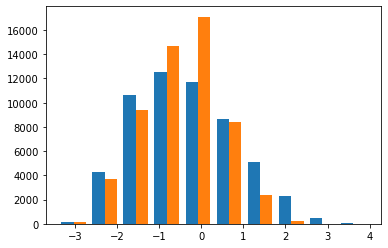

In [101]:
plt.hist(y_test_stats)

(array([[4.7673e+04, 8.2620e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.5630e+03,
         1.0965e+04, 2.0139e+04, 1.8229e+04, 4.7960e+03, 2.4200e+02]]),
 array([-0.53906902,  2.41788945,  5.37484791,  8.33180637, 11.28876484,
        14.2457233 , 17.20268177, 20.15964023, 23.1165987 , 26.07355716,
        29.03051562]),
 <a list of 2 BarContainer objects>)

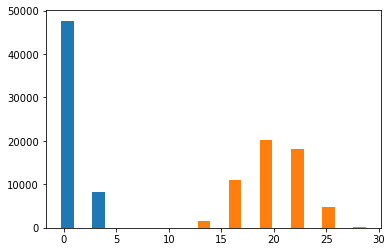

In [102]:
plt.hist((y_test_stats * std_of_stats) + mean_of_stats)

In [104]:
y_test_stats = (y_test_stats * std_of_stats) + mean_of_stats

In [105]:
y_test_stats

array([[ 2.01620992, 21.07083919],
       [ 2.55857181, 23.64582552],
       [ 1.8937779 , 19.68329386],
       ...,
       [ 0.80630821, 19.9575303 ],
       [ 1.09424633, 20.17219735],
       [ 2.38743708, 19.66720035]])

In [106]:
%pwd

'/home/jovyan/kaggle/working'

In [107]:
%cd multi_pca
np.savetxt("targets_norm_128_stats.csv", y_test_stats, delimiter=",")

/home/jovyan/kaggle/working/multi_pca


In [108]:
%cd /home/jovyan/kaggle/working

targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
pca_train = TruncatedSVD(n_components=128, random_state=1)
pca_train.fit(targets)

/home/jovyan/kaggle/working


TruncatedSVD(n_components=128, random_state=1)

In [ ]:
pca_train.inverse_transform()

In [111]:
multi_y_pred.shape

(55935, 128)

In [112]:
y_test_stats.shape

(55935, 2)

In [120]:
multi_y_pred_scaled = np.zeros_like(multi_y_pred)
for n,(i,j) in enumerate(zip(multi_y_pred,y_test_stats)):
    multi_y_pred_scaled[n] = i*j[1]+j[0]

In [121]:
multi_y_pred_scaled

array([[ 46.726433  ,   8.441428  ,  -4.310465  , ...,   0.1269958 ,
          0.14636433,   0.13772595],
       [ 50.530254  ,   5.7887063 ,   3.3795002 , ...,   0.45361733,
          0.41843462,   0.43966174],
       [ 44.69532   ,   7.455028  ,  -3.600696  , ...,   0.10943484,
          0.19577038,   0.11136842],
       ...,
       [ 47.25583   , -12.872827  ,  -3.1590798 , ...,  -0.98282343,
         -1.0331919 ,  -0.95419055],
       [ 58.490356  , -14.646929  ,  -3.985962  , ...,  -0.8769226 ,
         -0.7966819 ,  -0.8467938 ],
       [ 48.20715   ,   2.0941007 ,  17.924417  , ...,   0.5094063 ,
          0.47915947,   0.37099314]], dtype=float32)

In [122]:
multi_y_pred_scaled_inv_pca = pca_train.inverse_transform(multi_y_pred_scaled)

In [123]:
multi_y_pred_scaled_inv_pca

array([[0.14158255, 0.05065309, 0.03909181, ..., 0.14264268, 0.270854  ,
        0.3596359 ],
       [0.13373956, 0.06237799, 0.11667583, ..., 0.2579311 , 0.32949778,
        0.39910063],
       [0.12572688, 0.04362172, 0.10762635, ..., 0.1585324 , 0.2301861 ,
        0.35761866],
       ...,
       [0.06597445, 0.07783534, 0.04166092, ..., 0.22947805, 0.09700552,
        0.5174245 ],
       [0.09187233, 0.10030759, 0.09609154, ..., 0.3082178 , 0.22288698,
        0.6709745 ],
       [0.15674214, 0.11267959, 0.08598881, ..., 0.2884215 , 1.103877  ,
        0.72712266]], dtype=float32)

In [124]:
multi_y_pred_scaled_inv_pca.shape

(55935, 22858)

In [126]:
multi_y_train -= multi_y_train.mean(axis=1).reshape(-1, 1)
multi_y_train /= multi_y_train.std(axis=1).reshape(-1, 1)

In [127]:
LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
model = fit(multi_X_train,multi_y_train,meta)

Epoch 1/1000
270/270 - 3s - loss: -9.4424e-01 - negative_correlation_loss: -9.6527e-01 - val_loss: -9.6955e-01 - val_negative_correlation_loss: -9.7537e-01 - lr: 0.0100 - 3s/epoch - 11ms/step
Epoch 2/1000
270/270 - 2s - loss: -9.7713e-01 - negative_correlation_loss: -9.8118e-01 - val_loss: -9.7364e-01 - val_negative_correlation_loss: -9.7670e-01 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 3/1000
270/270 - 2s - loss: -9.7928e-01 - negative_correlation_loss: -9.8198e-01 - val_loss: -9.7474e-01 - val_negative_correlation_loss: -9.7724e-01 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 4/1000
270/270 - 2s - loss: -9.7983e-01 - negative_correlation_loss: -9.8222e-01 - val_loss: -9.7521e-01 - val_negative_correlation_loss: -9.7757e-01 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 5/1000
270/270 - 2s - loss: -9.8004e-01 - negative_correlation_loss: -9.8233e-01 - val_loss: -9.7572e-01 - val_negative_correlation_loss: -9.7797e-01 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 6/1000
270/270 - 2s - loss: -9.8014e-0

In [128]:
y_train_pred = model.predict(multi_X_train)
y_train_stats = mean_model.predict(multi_X_train)
y_train_pred_scaled = np.zeros_like(y_train_pred)
for n,(i,j) in enumerate(zip(y_train_pred,y_train_stats)):
    y_train_pred_scaled[n] = i*j[1]+j[0]
y_train_pred_scaled_inv_pca = pca_train.inverse_transform(y_train_pred_scaled)

3311/3311 [==============================] - 7s 2ms/step


FileNotFoundError: [Errno 2] No such file or directory: './sparse/train_multi_targets_values.sparse.npz'

In [131]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)

TypeError: mean() received an invalid combination of arguments - got (numpy.ndarray, int, keepdim=bool), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: keepdim
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [134]:
y_train_pred_scaled_inv_pca.shape

(105942, 22858)

In [135]:
targets.shape

(105942, 22858)

In [138]:
correlation_score(targets.toarray(), y_train_pred_scaled_inv_pca)

0.03539031830086233

In [139]:
targets.toarray()

array([[0.      , 0.      , 0.      , ..., 5.583255, 0.      , 4.893861],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 5.107832],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 4.871117, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 5.659341, 0.      , 0.      ]],
      dtype=float32)

In [140]:
y_train_pred_scaled_inv_pca

array([[ 0.00075762,  0.01520808, -0.08413149, ..., -0.01140444,
        -0.07104846,  0.06521034],
       [-0.00927807, -0.00084365, -0.00328598, ..., -0.00150079,
        -0.02118606,  0.00110913],
       [ 0.0011094 ,  0.00932492, -0.05034568, ..., -0.00568347,
        -0.04091938,  0.04171119],
       ...,
       [ 0.00182567,  0.00709409, -0.03324891, ..., -0.00102309,
        -0.02476752,  0.03484032],
       [-0.00013493,  0.00375737, -0.02302961, ..., -0.0052927 ,
        -0.01985279,  0.01426365],
       [-0.00380848,  0.01843137, -0.12515828, ..., -0.03083089,
        -0.11322439,  0.06653129]], dtype=float32)

In [141]:
correlation_score(pca_train.transform(targets),y_train_pred_scaled)

0.02947666217034837

In [143]:
abc = pca_train.transform(targets)
abc -= abc.mean(axis=1).reshape(-1, 1)
abc /= abc.std(axis=1).reshape(-1, 1)

In [144]:
correlation_score(abc,y_train_pred)

0.9830264981085174

In [145]:
abb = y_train_pred * abc.std(axis=1).reshape(-1, 1)
abb = abb + abc.mean(axis=1).reshape(-1, 1)
correlation_score(pca_train.transform(targets),abb)

0.983026498101876

In [146]:
y_train_stats

array([[-1.1297002 , -0.18777321],
       [-0.14538161, -1.0445625 ],
       [-0.66118747,  0.04484432],
       ...,
       [-0.42734846,  0.26948255],
       [-0.32387027, -0.27197394],
       [-1.7971483 , -2.04434   ]], dtype=float32)

In [147]:
normed_y_train_stats = (y_train_stats * std_of_stats) + mean_of_stats

In [148]:
normed_y_train_stats

array([[ 0.97703497, 20.34570853],
       [ 1.64748717, 17.76798259],
       [ 1.2961546 , 21.04555887],
       ...,
       [ 1.45543015, 21.72140279],
       [ 1.52591259, 20.09238323],
       [ 0.52241376, 14.76006407]])

In [149]:
y_train_pred_scaled = np.zeros_like(y_train_pred)
for n,(i,j) in enumerate(zip(y_train_pred,normed_y_train_stats)):
    y_train_pred_scaled[n] = i*j[1]+j[0]
y_train_pred_scaled_inv_pca = pca_train.inverse_transform(y_train_pred_scaled)
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
correlation_score(targets.toarray(), y_train_pred_scaled_inv_pca)

0.6575366107850737

In [150]:
correlation_score(pca_train.transform(targets), y_train_pred_scaled)

0.9830264981032376

In [13]:
# VERBOSE = 2
# targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
# targets = scprep.filter.remove_empty_genes(targets)
# # Normalize the targets row-wise: This doesn't change the correlations,
# # and negative_correlation_loss depends on it
# targets -= targets.mean(axis=1).reshape(-1, 1)
# targets /= targets.std(axis=1).reshape(-1, 1)

# pca_train = TruncatedSVD(n_components=128, random_state=1)
# pca_targets = pca_train.fit_transform(targets)

LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
model = fit(multi_X_train,pca_targets,meta)

2022-11-02 23:52:39.496147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 23:52:39.497106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-02 23:52:39.497738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-02 23:52:39.497995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

Epoch 1/1000
270/270 - 3s - loss: -8.6904e+00 - negative_correlation_loss: -8.7583e+00 - val_loss: -8.7469e+00 - val_negative_correlation_loss: -8.7906e+00 - lr: 0.0100 - 3s/epoch - 12ms/step
Epoch 2/1000
270/270 - 2s - loss: -8.8603e+00 - negative_correlation_loss: -8.8965e+00 - val_loss: -8.7686e+00 - val_negative_correlation_loss: -8.7991e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 3/1000
270/270 - 2s - loss: -8.8764e+00 - negative_correlation_loss: -8.9042e+00 - val_loss: -8.7751e+00 - val_negative_correlation_loss: -8.8003e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 4/1000
270/270 - 2s - loss: -8.8829e+00 - negative_correlation_loss: -8.9073e+00 - val_loss: -8.7834e+00 - val_negative_correlation_loss: -8.8067e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 5/1000
270/270 - 2s - loss: -8.8864e+00 - negative_correlation_loss: -8.9091e+00 - val_loss: -8.7893e+00 - val_negative_correlation_loss: -8.8109e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 6/1000
270/270 - 2s - loss: -8.8890e+0

In [14]:
correlation_score(targets,pca_train.inverse_transform(model.predict(multi_X_train)))

3311/3311 [==============================] - 7s 2ms/step


0.6572131474162176

In [16]:
pca_targets

array([[ 96.75895   ,   2.7196717 ,  -6.6861234 , ...,   0.2287289 ,
         -1.2928412 ,   1.6107945 ],
       [ 90.68708   ,  39.3617    ,   3.4871614 , ...,  -1.3762586 ,
          0.400674  ,  -0.6611794 ],
       [ 93.53362   ,   4.350221  ,  -1.340466  , ...,  -1.5267378 ,
         -1.033648  ,   0.34245542],
       ...,
       [ 99.821075  , -24.800884  ,  -7.6014423 , ...,  -1.9411163 ,
         -1.5029633 ,   0.2864661 ],
       [ 91.02533   ,   2.438875  ,  14.581878  , ...,   1.953774  ,
          0.85188013,  -0.8442121 ],
       [ 74.90686   , -25.215921  ,  19.704288  , ...,   4.082716  ,
         -0.6349184 ,  -1.7248564 ]], dtype=float32)

In [151]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=128, random_state=1)
pca_targets = pca_train.fit_transform(targets)

model = fit(multi_X_train,pca_targets,meta)

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Epoch 1/1000
270/270 - 3s - loss: -8.6882e+00 - negative_correlation_loss: -8.7533e+00 - val_loss: -8.7500e+00 - val_negative_correlation_loss: -8.7926e+00 - lr: 0.0100 - 3s/epoch - 12ms/step
Epoch 2/1000
270/270 - 2s - loss: -8.8602e+00 - negative_correlation_loss: -8.8958e+00 - val_loss: -8.7682e+00 - val_negative_correlation_loss: -8.7982e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 3/1000
270/270 - 2s - loss: -8.8761e+00 - negative_correlation_loss: -8.9036e+00 - val_loss: -8.7786e+00 - val_negative_correlation_loss: -8.8035e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 4/1000
270/270 - 2s - loss: -8.8833e+00 - negative_correlation_loss: -8.9073e+00 - val_loss: -8.7798e+00 - val_negative_correlation_loss: -8.8027e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 5/1000
270/270 - 2s - loss: -8.8868e+00 - negative_correlation_loss: -8.9092e+00 - val_loss: -8.7869e+00 - val_negative_correlation_loss: -8.8083e+00 - lr: 0.0100 - 2s/epoch - 8ms/step
Epoch 6/1000
270/270 - 2s - loss: -8.8893e+0

In [152]:
correlation_score(targets,pca_train.inverse_transform(model.predict(multi_X_train)))

3311/3311 [==============================] - 7s 2ms/step


0.6632218086473645

In [154]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=512, random_state=1)
pca_targets = pca_train.fit_transform(targets)

model = fit(multi_X_train,pca_targets,meta)
correlation_score(targets,pca_train.inverse_transform(model.predict(multi_X_train)))

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Epoch 1/1000
270/270 - 3s - loss: -4.3168e+00 - negative_correlation_loss: -4.3639e+00 - val_loss: -4.3709e+00 - val_negative_correlation_loss: -4.3972e+00 - lr: 0.0100 - 3s/epoch - 13ms/step
Epoch 2/1000
270/270 - 3s - loss: -4.4328e+00 - negative_correlation_loss: -4.4546e+00 - val_loss: -4.3841e+00 - val_negative_correlation_loss: -4.4032e+00 - lr: 0.0100 - 3s/epoch - 10ms/step
Epoch 3/1000
270/270 - 3s - loss: -4.4406e+00 - negative_correlation_loss: -4.4588e+00 - val_loss: -4.3882e+00 - val_negative_correlation_loss: -4.4055e+00 - lr: 0.0100 - 3s/epoch - 10ms/step
Epoch 4/1000
270/270 - 3s - loss: -4.4440e+00 - negative_correlation_loss: -4.4612e+00 - val_loss: -4.3926e+00 - val_negative_correlation_loss: -4.4095e+00 - lr: 0.0100 - 3s/epoch - 10ms/step
Epoch 5/1000
270/270 - 3s - loss: -4.4459e+00 - negative_correlation_loss: -4.4628e+00 - val_loss: -4.3939e+00 - val_negative_correlation_loss: -4.4104e+00 - lr: 0.0100 - 3s/epoch - 10ms/step
Epoch 6/1000
270/270 - 3s - loss: -4.447

0.6599860343421647

In [160]:
abc = np.zeros(512)
abc[0]=1
first = pca_train.inverse_transform(abc.reshape(1, -1))

In [176]:
len(first[0])

22858

In [180]:
np.sort(first[0])[::-1][0:2000]

array([0.04911358, 0.04724192, 0.04637691, ..., 0.01052904, 0.01052624,
       0.01051622])

In [215]:
correlation_score_cols(targets,pca_train.inverse_transform(model.predict(multi_X_train)))

3311/3311 [==============================] - 8s 2ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 105942

In [196]:
correlation_score_cols(np.array([[2,6]]),np.array([[-2,1]]))

/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


nan

In [214]:
correlation_score_cols(np.array([[2,3],[6,5]]),np.array([[-6,5],[2,2]]))

0.9999999999999999
-1.0


-5.551115123125783e-17

In [218]:
correlation_score_cols(np.random.rand(100,10),np.random.rand(100,10))

-0.04452893479881931
0.047176655826038694
-0.10181792269436003
0.09367030721384695
-0.07599827463948759
-0.134907914005699
0.02202780035087165
0.029332824264740986
-0.11453669682015295
0.10328343503465327


-0.017629872026836736

In [219]:
correlation_score(np.random.rand(100,10),np.random.rand(100,10))

-0.02008743285505159

In [220]:
abc = pca_train.inverse_transform(model.predict(multi_X_train))

3311/3311 [==============================] - 7s 2ms/step


In [3]:
correlation_score_cols(targets,targets)

NameError: name 'targets' is not defined

In [4]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)


AttributeError: 'float' object has no attribute 'shape'

In [12]:
abc = targets.toarray()

In [11]:
np.array(targets[:,0]).shape

()

In [20]:
%cd ..
cite_targets = scipy.sparse.load_npz("./sparse/train_cite_targets_values.sparse.npz")
cite_targets = scprep.filter.remove_empty_genes(cite_targets)

/home/jovyan/kaggle/working


In [21]:
cite_targets -= cite_targets.mean(axis=1).reshape(-1, 1)
cite_targets /= cite_targets.std(axis=1).reshape(-1, 1)

In [17]:
%cd pca64
%ls

/home/jovyan/kaggle/working/pca64
X_test_64.csv  X_train_64.csv


In [271]:
X_train_64 = np.genfromtxt("./pca64/X_train_64.csv", delimiter=',')

In [18]:
X_train_64 = np.genfromtxt("X_train_64.csv", delimiter=',')

In [23]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cite_index = data['index']

metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cite_index)

In [25]:
LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
model_cite = fit(X_train_64,cite_targets,meta)

2022-10-14 19:59:31.022519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 19:59:31.023452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-14 19:59:31.023473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-14 19:59:31.024678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

Epoch 1/1000
181/181 - 3s - loss: -8.3367e-01 - negative_correlation_loss: -8.5967e-01 - val_loss: -8.6289e-01 - val_negative_correlation_loss: -8.7795e-01 - lr: 0.0100 - 3s/epoch - 16ms/step
Epoch 2/1000
181/181 - 2s - loss: -8.8281e-01 - negative_correlation_loss: -8.9465e-01 - val_loss: -8.6907e-01 - val_negative_correlation_loss: -8.7877e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 3/1000
181/181 - 2s - loss: -8.8812e-01 - negative_correlation_loss: -8.9684e-01 - val_loss: -8.7411e-01 - val_negative_correlation_loss: -8.8187e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 4/1000
181/181 - 2s - loss: -8.9020e-01 - negative_correlation_loss: -8.9760e-01 - val_loss: -8.7411e-01 - val_negative_correlation_loss: -8.8111e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 5/1000
181/181 - 2s - loss: -8.9143e-01 - negative_correlation_loss: -8.9807e-01 - val_loss: -8.7591e-01 - val_negative_correlation_loss: -8.8229e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 6/1000
181/181 - 2s - loss: -8.9224e-0

In [70]:
abc = model_cite.predict(X_train_64)

2219/2219 [==============================] - 5s 2ms/step


In [72]:
cite_targets.mean(axis=0)

matrix([[-0.43837434, -0.43021062, -0.29833534,  1.1338654 ,  1.0635331 ,
          1.6808542 ,  0.5861186 , -0.45797923, -0.36173666, -0.32925007,
         -0.5392869 , -0.44224316, -0.41343763, -0.40785432,  1.698253  ,
         -0.30666706,  1.3430887 ,  0.10360113,  0.26428685, -0.41626763,
         -0.39041537,  0.65044415, -0.50409716, -0.33956006,  2.8327327 ,
         -0.47129494, -0.5209527 , -0.5048487 , -0.47144407, -0.43777195,
         -0.46311662, -0.39903826, -0.4383445 , -0.44194743, -0.43680227,
         -0.48774657, -0.3047757 ,  3.5374074 , -0.33286268, -0.39105356,
         -0.4867969 , -0.40290892, -0.46317026,  0.40630922, -0.53387964,
         -0.43826064, -0.25131822, -0.38530982,  1.4767705 , -0.48534304,
         -0.3739072 , -0.4384068 , -0.23403381, -0.5170458 , -0.02530339,
         -0.09405742, -0.43527642,  0.9401281 , -0.48003206, -0.4430905 ,
         -0.4793237 , -0.37314054, -0.3362626 , -0.39815608, -0.47443724,
         -0.3418427 , -0.20295967, -0.

In [71]:
abc.mean(axis=0)

array([-0.9476678 , -0.92181164, -0.6649792 ,  2.1446197 ,  2.03047   ,
        3.4222095 ,  1.3197931 , -1.0004737 , -0.79381233, -0.7329463 ,
       -1.1308562 , -0.949798  , -0.8529651 , -0.9006047 ,  3.297998  ,
       -0.691149  ,  2.7020054 ,  0.19542207,  0.7029529 , -0.8933938 ,
       -0.8832023 ,  1.2094705 , -1.0667897 , -0.7351041 ,  5.5794687 ,
       -1.0051723 , -1.1013024 , -1.0571693 , -1.0106857 , -0.94480383,
       -0.98906326, -0.8597457 , -0.9345949 , -0.9431606 , -0.9379719 ,
       -1.0335352 , -0.65234506,  7.18215   , -0.7579878 , -0.8366694 ,
       -1.026308  , -0.8654688 , -0.96377873,  0.8200831 , -1.1100826 ,
       -0.93828523, -0.56664515, -0.82666415,  3.059695  , -1.0327083 ,
       -0.81892127, -0.9502457 , -0.44706813, -1.0911546 , -0.10604908,
       -0.2508806 , -0.9200543 ,  1.8921261 , -1.0059807 , -0.94723076,
       -1.0281626 , -0.7956708 , -0.7277675 , -0.85454345, -1.0022562 ,
       -0.753068  , -0.48845705, -0.6446871 ,  0.76635545, -1.00

In [100]:
abc / meansabc[0]

matrix([[-0.4962811 , -0.43986705, -0.32911724, ..., -0.3991146 ,
          0.09072484,  0.05828905],
        [-0.4469169 , -0.39205334, -0.29057032, ..., -0.37345508,
          0.25327104, -0.04370385],
        [-0.37373018, -0.3195325 , -0.19469908, ..., -0.37192178,
          1.7707909 ,  0.25211993],
        ...,
        [-0.5394694 , -0.42162403, -0.22672693, ..., -0.4636499 ,
          2.4642158 ,  0.7324886 ],
        [-0.36571398, -0.45295855, -0.27836773, ..., -0.3658736 ,
          0.8237045 ,  0.38593206],
        [-0.43379724, -0.33250508, -0.22546841, ..., -0.36630312,
          1.5782167 ,  0.5842248 ]], dtype=float32)

In [99]:
meansabc = abc.mean(axis=0)/cite_targets.mean(axis=0)

In [75]:
(abc.mean(axis=0)/cite_targets.mean(axis=0)).mean()

2.1477606

In [33]:
abc

array([[-1.0728493 , -0.9425025 , -0.73359096, ..., -0.83443344,
         0.15473872,  0.10812813],
       [-0.9661349 , -0.8400521 , -0.6476712 , ..., -0.78078675,
         0.4319747 , -0.08107209],
       [-0.8079215 , -0.68466187, -0.43397754, ..., -0.7775811 ,
         3.0202305 ,  0.46769086],
       ...,
       [-1.1662128 , -0.9034132 , -0.5053665 , ..., -0.9693581 ,
         4.202924  ,  1.3587906 ],
       [-0.79059225, -0.97055364, -0.6204721 , ..., -0.7649361 ,
         1.4048961 ,  0.71591675],
       [-0.9377731 , -0.71245813, -0.50256133, ..., -0.7658341 ,
         2.6917791 ,  1.0837564 ]], dtype=float32)

In [79]:
(abc/2.1477606).mean(axis=0)

array([-0.44123948, -0.42920062, -0.30961725,  0.9985407 ,  0.94539154,
        1.593381  ,  0.6144963 , -0.4658228 , -0.36959738, -0.34125805,
       -0.52653104, -0.4422284 , -0.39714387, -0.41932556,  1.5355524 ,
       -0.32180047,  1.2580388 ,  0.09098835,  0.32729363, -0.4159678 ,
       -0.4112222 ,  0.5631243 , -0.49669284, -0.3422681 ,  2.597824  ,
       -0.46801582, -0.5127656 , -0.4922174 , -0.47057435, -0.43989697,
       -0.46050477, -0.400302  , -0.4351503 , -0.43913975, -0.43672082,
       -0.48121607, -0.3037326 ,  3.3440146 , -0.35292205, -0.38955262,
       -0.4778545 , -0.4029637 , -0.44873315,  0.38183406, -0.51685476,
       -0.43686986, -0.26383075, -0.3848931 ,  1.4246153 , -0.48082826,
       -0.38129044, -0.44243598, -0.20815673, -0.5080364 , -0.04937639,
       -0.11681044, -0.42837992,  0.88098186, -0.4683849 , -0.44103214,
       -0.4787128 , -0.37046725, -0.33884773, -0.39787838, -0.46664837,
       -0.35062802, -0.22742411, -0.30016723,  0.35681644, -0.46

In [32]:
cite_targets

matrix([[ 0.09460447, -0.16236247, -0.40533194, ..., -0.2604974 ,
          0.38325763, -0.19745262],
        [-0.25125083, -0.35797054, -0.16268902, ..., -0.19555242,
          0.40262994,  0.21424626],
        [-0.5045346 , -0.52717906, -0.6661142 , ..., -0.78993785,
          0.9858621 ,  0.6095203 ],
        ...,
        [-0.21439946, -0.42171356, -0.15420535, ..., -0.28104922,
          1.3694407 ,  0.39634088],
        [-0.59204555, -0.8529565 , -0.36310583, ..., -0.15817975,
          0.16098164,  0.7527571 ],
        [-0.64900035, -0.6185921 , -0.27466986, ..., -0.3303311 ,
          1.6578442 ,  0.4573473 ]], dtype=float32)

In [91]:
abc

array([[-1.0728493 , -0.9425025 , -0.73359096, ..., -0.83443344,
         0.15473872,  0.10812813],
       [-0.9661349 , -0.8400521 , -0.6476712 , ..., -0.78078675,
         0.4319747 , -0.08107209],
       [-0.8079215 , -0.68466187, -0.43397754, ..., -0.7775811 ,
         3.0202305 ,  0.46769086],
       ...,
       [-1.1662128 , -0.9034132 , -0.5053665 , ..., -0.9693581 ,
         4.202924  ,  1.3587906 ],
       [-0.79059225, -0.97055364, -0.6204721 , ..., -0.7649361 ,
         1.4048961 ,  0.71591675],
       [-0.9377731 , -0.71245813, -0.50256133, ..., -0.7658341 ,
         2.6917791 ,  1.0837564 ]], dtype=float32)

In [109]:
temp = correlation_score_cols(abc,np.array(cite_targets))

0.33925155837905796


In [110]:
np.max(temp)

0.8854976107755664

In [111]:
np.min(temp)

0.06820730312521649

(array([39., 22., 16., 15.,  9.,  7., 14.,  6.,  6.,  6.]),
 array([0.0682073 , 0.14993633, 0.23166536, 0.3133944 , 0.39512343,
        0.47685246, 0.55858149, 0.64031052, 0.72203955, 0.80376858,
        0.88549761]),
 <BarContainer object of 10 artists>)

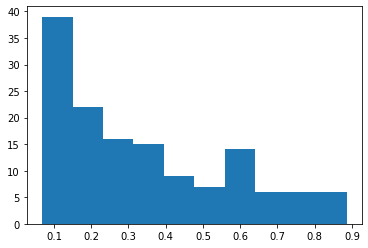

In [112]:
plt.hist(temp)

In [41]:
np.array(cite_targets).shape

(70988, 140)

In [44]:
correlation_score(abc,np.array(cite_targets))

0.8997113945543967

In [67]:
LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
model_cite_col = fit(X_train_64,cite_targets,meta, loss= negative_correlation_loss_col)

Epoch 1/1000


TypeError: in user code:

    File "/srv/conda/envs/saturn/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_27569/3330374890.py", line 109, in negative_correlation_loss_col  *
        r_den = tf.sqrt(K.sum(K.square(ym), axis=0) * float(y_true.shape[0]))

    TypeError: float() argument must be a string or a number, not 'NoneType'


In [114]:
abc[:,0]

array([-1.0728493 , -0.9661349 , -0.8079215 , ..., -1.1662128 ,
       -0.79059225, -0.9377731 ], dtype=float32)

In [115]:
cite_targets[:,0]

matrix([[ 0.09460447],
        [-0.25125083],
        [-0.5045346 ],
        ...,
        [-0.21439946],
        [-0.59204555],
        [-0.64900035]], dtype=float32)

In [116]:
abc[0]

array([-1.0728493 , -0.9425025 , -0.73359096,  2.0403044 ,  2.6997807 ,
        4.469286  ,  1.9709723 , -1.0855398 , -0.85121953, -0.7432416 ,
       -1.0990071 , -1.0225997 , -0.7872801 , -1.0525746 ,  1.8934639 ,
       -0.9000117 ,  3.3920686 ,  0.8743653 ,  1.7360687 , -0.86792517,
       -0.7658537 ,  0.83408344, -1.0618287 , -0.8354715 ,  7.6926937 ,
       -0.9864567 , -1.1039817 , -1.0144945 , -1.0746341 , -0.9557871 ,
       -1.0214843 , -0.92580837, -0.9350562 , -0.9748629 , -0.95204556,
       -1.0073638 , -0.8115264 ,  9.01762   , -0.90699   , -0.7870076 ,
       -1.0670189 , -0.9674368 , -1.0029871 , -1.0227884 , -1.0522118 ,
       -0.9288676 , -0.8599534 , -0.8463661 ,  6.240193  , -0.98756635,
       -0.9016222 , -0.95247877, -0.9094094 , -1.0708177 , -0.3067628 ,
       -0.20908771, -0.9932799 ,  2.6763663 , -1.0265197 , -0.979298  ,
       -1.1242805 , -0.8063568 , -0.83312106, -0.9007708 , -1.0487636 ,
       -0.92716706, -0.8404147 , -0.7792358 ,  0.4712815 , -1.03

In [117]:
cite_targets[0]

matrix([[ 0.09460447, -0.16236247, -0.40533194, -0.30258217,  1.1143553 ,
          2.5725956 ,  0.24209179, -0.79900104, -0.6766891 , -0.49027386,
         -0.41616368, -0.46010295, -0.83592623, -0.58081967,  1.3126783 ,
         -0.38563633,  1.9725535 ,  0.30078298,  0.15214825, -0.47084144,
         -0.46137574, -0.08522395, -0.5401505 ,  0.30790612,  3.8155568 ,
         -0.6566035 , -0.06219612, -0.33673298, -0.8480253 , -0.6433275 ,
         -0.79328525, -0.39329565, -0.47194415, -0.4142395 ,  0.019964  ,
         -0.3972386 , -0.3869004 ,  6.4238887 , -0.4234315 , -0.6023517 ,
         -0.2807335 , -0.3338139 , -0.34352177, -0.40888563,  0.13996255,
         -0.28898895, -0.12864116,  0.19087504,  2.6287313 , -0.649598  ,
         -0.83859944,  0.43944177, -0.5918909 , -0.5002184 , -0.3030655 ,
          0.2126235 , -0.50036937,  1.2369651 ,  0.01480785, -0.06780977,
         -0.55614567, -0.8452714 , -0.37435248, -1.2261416 , -0.49511486,
         -0.40094125,  0.0683836 , -0.

In [118]:
np.corrcoef(np.array(cite_targets[0]),abc[0])

array([[1.        , 0.90748178],
       [0.90748178, 1.        ]])

In [119]:
abc[0].mean()

-0.050308023

In [120]:
cite_targets[0].mean()

-1.6178404e-08

In [127]:
abc[500].mean()

-0.089410014

In [128]:
cite_targets[500].mean()

6.8119594e-09

In [130]:
abc.mean(axis = 1)

array([-0.05030802, -0.06314769, -0.04427298, ..., -0.0016842 ,
       -0.06215657, -0.07001297], dtype=float32)

In [132]:
abc -= abc.mean(axis=1).reshape(-1, 1)
abc /= abc.std(axis=1).reshape(-1, 1)

In [133]:
temp = correlation_score_cols(abc,np.array(cite_targets))

0.3823501642691885


(array([38., 23., 17., 17.,  7.,  4., 14.,  6.,  7.,  7.]),
 array([0.1190214 , 0.19802707, 0.27703274, 0.35603841, 0.43504409,
        0.51404976, 0.59305543, 0.6720611 , 0.75106678, 0.83007245,
        0.90907812]),
 <BarContainer object of 10 artists>)

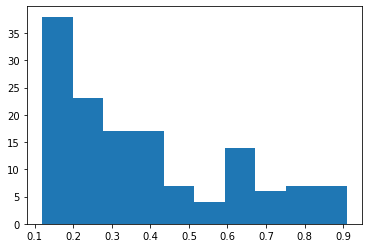

In [135]:
plt.hist(temp)

In [136]:
np.min(temp)

0.11902139601380284

In [137]:
np.max(temp)

0.9090781231219907

In [138]:
np.sort(temp)[::-1]

array([0.90907812, 0.87674004, 0.85677523, 0.8468331 , 0.84514354,
       0.83540512, 0.834092  , 0.80151775, 0.79518633, 0.78023991,
       0.77869873, 0.77066477, 0.76032564, 0.75186689, 0.72053664,
       0.72021451, 0.7077698 , 0.70231088, 0.68367192, 0.6735132 ,
       0.66640912, 0.65060906, 0.65053488, 0.64887687, 0.64771438,
       0.64506442, 0.63061682, 0.62816246, 0.6254363 , 0.62211454,
       0.61424204, 0.60576244, 0.60492658, 0.59405594, 0.52942215,
       0.52436242, 0.52163628, 0.51703432, 0.50994949, 0.50768719,
       0.50452654, 0.50307413, 0.45886597, 0.44919342, 0.4415431 ,
       0.43008516, 0.42919073, 0.41795663, 0.41609959, 0.4156465 ,
       0.41382087, 0.41076895, 0.4087401 , 0.40647809, 0.39738827,
       0.38874933, 0.3870026 , 0.37329839, 0.37300181, 0.36950014,
       0.36641478, 0.35655931, 0.35566646, 0.35520699, 0.35006071,
       0.34777627, 0.34055463, 0.33109092, 0.3196428 , 0.31904042,
       0.31596628, 0.31523315, 0.3085969 , 0.30824403, 0.30459

(array([97., 12., 11.,  4.,  5.,  5.,  1.,  3.,  1.,  1.]),
 array([-0.5392869 , -0.13161749,  0.27605194,  0.68372136,  1.0913908 ,
         1.4990603 ,  1.9067297 ,  2.314399  ,  2.7220685 ,  3.1297379 ,
         3.5374074 ], dtype=float32),
 <BarContainer object of 10 artists>)

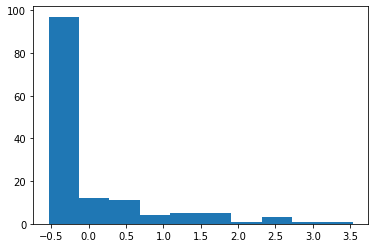

In [140]:
plt.hist(np.array(cite_targets).mean(axis=0))

(array([92., 15., 10.,  9.,  3.,  2.,  8.,  0.,  0.,  1.]),
 array([0.22220087, 0.40490893, 0.587617  , 0.770325  , 0.9530331 ,
        1.1357411 , 1.3184491 , 1.5011572 , 1.6838653 , 1.8665733 ,
        2.0492814 ], dtype=float32),
 <BarContainer object of 10 artists>)

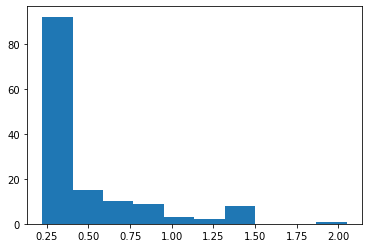

In [142]:
plt.hist(np.array(cite_targets).std(axis=0))

(array([9.0000e+00, 1.4200e+02, 1.3270e+03, 8.4270e+03, 2.4758e+04,
        2.5428e+04, 9.2900e+03, 1.4580e+03, 1.3900e+02, 1.0000e+01]),
 array([-1.7540795e-07, -1.4117785e-07, -1.0694776e-07, -7.2717661e-08,
        -3.8487567e-08, -4.2574726e-09,  2.9972622e-08,  6.4202716e-08,
         9.8432814e-08,  1.3266290e-07,  1.6689300e-07], dtype=float32),
 <BarContainer object of 10 artists>)

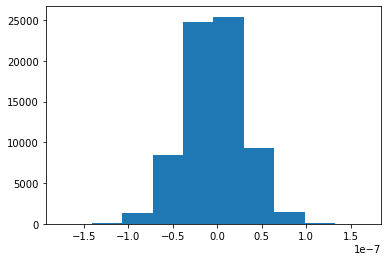

In [141]:
plt.hist(np.array(cite_targets).mean(axis=1))

In [143]:
%pwd

'/home/jovyan/kaggle/working'

In [152]:
important_cols = ['ENSG00000114013_CD86', 'ENSG00000120217_CD274', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000169442_CD52', 'ENSG00000117528_ABCD3', 'ENSG00000168014_C2CD3', 'ENSG00000167851_CD300A', 'ENSG00000167850_CD300C', 'ENSG00000186407_CD300E', 'ENSG00000178789_CD300LB', 'ENSG00000186074_CD300LF', 'ENSG00000241399_CD302', 'ENSG00000167775_CD320', 'ENSG00000105383_CD33', 'ENSG00000174059_CD34', 'ENSG00000135218_CD36', 'ENSG00000104894_CD37', 'ENSG00000004468_CD38', 'ENSG00000167286_CD3D', 'ENSG00000198851_CD3E', 'ENSG00000117877_CD3EAP', 'ENSG00000074696_HACD3', 'ENSG00000015676_NUDCD3', 'ENSG00000161714_PLCD3', 'ENSG00000132300_PTCD3', 'ENSG00000082014_SMARCD3', 'ENSG00000121594_CD80', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000066294_CD84', 'ENSG00000114013_CD86', 'ENSG00000172116_CD8B', 'ENSG00000254126_CD8B2', 'ENSG00000177455_CD19', 'ENSG00000105383_CD33', 'ENSG00000173762_CD7', 'ENSG00000125726_CD70', 'ENSG00000137101_CD72', 'ENSG00000019582_CD74', 'ENSG00000105369_CD79A', 'ENSG00000007312_CD79B', 'ENSG00000090470_PDCD7', 'ENSG00000119688_ABCD4', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000026508_CD44', 'ENSG00000117335_CD46', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000188921_HACD4', 'ENSG00000150593_PDCD4', 'ENSG00000203497_PDCD4-AS1', 'ENSG00000115556_PLCD4', 'ENSG00000026508_CD44', 'ENSG00000170458_CD14', 'ENSG00000117281_CD160', 'ENSG00000177575_CD163', 'ENSG00000135535_CD164', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000182685_BRICD5', 'ENSG00000111731_C2CD5', 'ENSG00000169442_CD52', 'ENSG00000143119_CD53', 'ENSG00000196352_CD55', 'ENSG00000116815_CD58', 'ENSG00000085063_CD59', 'ENSG00000105185_PDCD5', 'ENSG00000255909_PDCD5P1', 'ENSG00000145284_SCD5', 'ENSG00000167775_CD320', 'ENSG00000110848_CD69', 'ENSG00000139187_KLRG1', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000204287_HLA-DRA', 'ENSG00000196126_HLA-DRB1', 'ENSG00000198502_HLA-DRB5', 'ENSG00000229391_HLA-DRB6', 'ENSG00000116815_CD58', 'ENSG00000168329_CX3CR1', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000122223_CD244', 'ENSG00000177575_CD163', 'ENSG00000112149_CD83', 'ENSG00000185963_BICD2', 'ENSG00000157617_C2CD2', 'ENSG00000172375_C2CD2L', 'ENSG00000116824_CD2', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000198087_CD2AP', 'ENSG00000169217_CD2BP2', 'ENSG00000144554_FANCD2', 'ENSG00000206527_HACD2', 'ENSG00000170584_NUDCD2', 'ENSG00000071994_PDCD2', 'ENSG00000126249_PDCD2L', 'ENSG00000049883_PTCD2', 'ENSG00000186193_SAPCD2', 'ENSG00000108604_SMARCD2', 'ENSG00000185561_TLCD2', 'ENSG00000075035_WSCD2', 'ENSG00000150637_CD226', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000134061_CD180', 'ENSG00000004468_CD38', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000135404_CD63', 'ENSG00000135218_CD36', 'ENSG00000137101_CD72', 'ENSG00000125810_CD93', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000153283_CD96', 'ENSG00000002586_CD99', 'ENSG00000102181_CD99L2', 'ENSG00000223773_CD99P1', 'ENSG00000204592_HLA-E', 'ENSG00000085117_CD82', 'ENSG00000134256_CD101']
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_columns = data['columns']
temp = np.array([])
for i in important_cols:
    temp = np.append(temp,np.where(cell_columns == i))
%cd sparse
np.savetxt("important_cols.csv",temp,delimiter=",")
%cd ..

/home/jovyan/kaggle/working/sparse
/home/jovyan/kaggle/working


In [260]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')

In [155]:
X_train.shape

(70988, 22050)

In [162]:
type(X_train_64)

numpy.ndarray

In [156]:
X_train_64.shape

(70988, 256)

In [163]:
type(X_train[:,temp])

scipy.sparse._csr.csr_matrix

In [164]:
X_train_cite = np.hstack([X_train_64,X_train[:,temp].toarray()])

In [165]:
LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
model_cite = fit(X_train_cite,cite_targets,meta)

Epoch 1/1000
181/181 - 3s - loss: -8.3255e-01 - negative_correlation_loss: -8.6062e-01 - val_loss: -8.6257e-01 - val_negative_correlation_loss: -8.7825e-01 - lr: 0.0100 - 3s/epoch - 14ms/step
Epoch 2/1000
181/181 - 2s - loss: -8.8325e-01 - negative_correlation_loss: -8.9555e-01 - val_loss: -8.6892e-01 - val_negative_correlation_loss: -8.7883e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 3/1000
181/181 - 2s - loss: -8.8858e-01 - negative_correlation_loss: -8.9753e-01 - val_loss: -8.7483e-01 - val_negative_correlation_loss: -8.8290e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 4/1000
181/181 - 2s - loss: -8.9076e-01 - negative_correlation_loss: -8.9846e-01 - val_loss: -8.7575e-01 - val_negative_correlation_loss: -8.8279e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 5/1000
181/181 - 2s - loss: -8.9199e-01 - negative_correlation_loss: -8.9880e-01 - val_loss: -8.7627e-01 - val_negative_correlation_loss: -8.8279e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 6/1000
181/181 - 2s - loss: -8.9266e-0

In [171]:
temp.dtype = int

In [169]:
delete_columns_csr(X_train,int(temp))

TypeError: only size-1 arrays can be converted to Python scalars

In [185]:
np.array(cite_targets[:,0].ravel())[0]

array([ 0.09460447, -0.25125083, -0.5045346 , ..., -0.21439946,
       -0.59204555, -0.64900035], dtype=float32)

In [186]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ld = LinearDiscriminantAnalysis()
important = np.genfromtxt("./sparse/important_cols.csv", delimiter=',', dtype = int)
ld.fit(delete_columns_csr(X_train,important).toarray(),np.array(cite_targets[:,0].ravel())[0])

ValueError: Unknown label type: (array([ 0.09460447, -0.25125083, -0.5045346 , ..., -0.21439946,
       -0.59204555, -0.64900035], dtype=float32),)

In [195]:
important = np.genfromtxt("./sparse/important_cols.csv", delimiter=',').astype(int)

In [196]:
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = delete_columns_csr(X_train,important)

In [197]:
X_train.shape

(70988, 21491)

In [198]:
type(cite_targets)

numpy.matrix

In [199]:
cite_targets = np.array(cite_targets)

In [200]:
cite_targets

array([[ 0.09460447, -0.16236247, -0.40533194, ..., -0.2604974 ,
         0.38325763, -0.19745262],
       [-0.25125083, -0.35797054, -0.16268902, ..., -0.19555242,
         0.40262994,  0.21424626],
       [-0.5045346 , -0.52717906, -0.6661142 , ..., -0.78993785,
         0.9858621 ,  0.6095203 ],
       ...,
       [-0.21439946, -0.42171356, -0.15420535, ..., -0.28104922,
         1.3694407 ,  0.39634088],
       [-0.59204555, -0.8529565 , -0.36310583, ..., -0.15817975,
         0.16098164,  0.7527571 ],
       [-0.64900035, -0.6185921 , -0.27466986, ..., -0.3303311 ,
         1.6578442 ,  0.4573473 ]], dtype=float32)

In [208]:
y_tr.shape

(46185, 140)

In [213]:
#X_train = torch.from_numpy(X_train)

#xx_train, _, xx_valid = torch.tensor_split(X_train, [60988,10000])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(1)
tf.random.set_seed(1)


kf = GroupKFold(n_splits=N_SPLITS)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):

    X_tr = X_train[idx_tr]
    y_tr = cite_targets[idx_tr]
    X_va = X_train[idx_va]
    y_va = cite_targets[idx_va]
    batch_size = 10000
    X_tr = torch.from_numpy(X_tr.toarray())
    y_tr = torch.from_numpy(y_tr)
    X_va = torch.from_numpy(X_va.toarray())
    y_va = torch.from_numpy(y_va)
    
    train_ds = TensorDataset(X_tr,y_tr)
    train_dl = DataLoader(train_ds, batch_size, drop_last = False)
    valid_ds = TensorDataset(X_va,y_va)
    valid_dl = DataLoader(valid_ds, batch_size, drop_last = False)

    loss_fn = negative_pearson_loss
    input_size = 21491
    output_size = 140
    learning_rate = 0.01
    num_epochs = 40
    log_epochs = 1
    lambda1 = 0.01
    #yy_train = torch.from_numpy(y_train)

    #yy_train, _, yy_valid = torch.tensor_split(yy_train, [60988,10000])


    # batch_size = 10000
    # train_ds = TensorDataset(xx_train,yy_train)
    # train_dl = DataLoader(train_ds, batch_size, drop_last = False)
    # valid_ds = TensorDataset(xx_valid,yy_valid)
    # valid_dl = DataLoader(valid_ds, batch_size, drop_last = False)

    # all_layers = []
    # temp_size = input_size
    # hidden_units = (1000,)
    # for hidden_unit in hidden_units:
    #   layer = nn.Linear(temp_size,hidden_unit)
    #   all_layers.append(layer)
    #   all_layers.append(nn.SiLU())
    #   temp_size = hidden_unit
    # all_layers.append(nn.Linear(hidden_units[-1],output_size))
    # model = nn.Sequential(*all_layers)
    model = nn.Linear(input_size, output_size)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            train_pearson = -loss_fn(pred, y_batch)
            all_linear1_params = torch.cat([x.view(-1) for x in model.parameters()])
            l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
            loss = -train_pearson + l1_regularization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for x_batch, y_batch in valid_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            valid_pearson = -loss_fn(pred, y_batch)
        if epoch % log_epochs == 0:
            print(f'Epoch {epoch} Train_Loss {train_pearson.item():.4f} Valid_Loss {valid_pearson.item():.4f} L1 Reg % {l1_regularization/loss:.2f} Non-zero/output {int(sum([torch.count_nonzero(p) for p in model.parameters()]))/output_size:.0f}')
    break

Epoch 0 Train_Loss 0.7839 Valid_Loss 0.7475 L1 Reg % 1.01 Non-zero/output 21492
Epoch 1 Train_Loss 0.7932 Valid_Loss 0.7522 L1 Reg % 1.01 Non-zero/output 21492
Epoch 2 Train_Loss 0.7967 Valid_Loss 0.7553 L1 Reg % 1.01 Non-zero/output 21492
Epoch 3 Train_Loss 0.7997 Valid_Loss 0.7580 L1 Reg % 1.02 Non-zero/output 21492
Epoch 4 Train_Loss 0.8023 Valid_Loss 0.7606 L1 Reg % 1.02 Non-zero/output 21492
Epoch 5 Train_Loss 0.8049 Valid_Loss 0.7632 L1 Reg % 1.02 Non-zero/output 21492
Epoch 6 Train_Loss 0.8075 Valid_Loss 0.7658 L1 Reg % 1.03 Non-zero/output 21492
Epoch 7 Train_Loss 0.8100 Valid_Loss 0.7681 L1 Reg % 1.04 Non-zero/output 21492
Epoch 8 Train_Loss 0.8079 Valid_Loss 0.7648 L1 Reg % 1.06 Non-zero/output 21492
Epoch 9 Train_Loss 0.7788 Valid_Loss 0.7335 L1 Reg % 1.09 Non-zero/output 21492
Epoch 10 Train_Loss 0.7510 Valid_Loss 0.7202 L1 Reg % 1.15 Non-zero/output 21492
Epoch 11 Train_Loss 0.7420 Valid_Loss 0.6908 L1 Reg % 1.28 Non-zero/output 21492
Epoch 12 Train_Loss 0.7097 Valid_Loss 

2.9208518e-11 0.014571045 5.5295164e-05 5.068843e-05


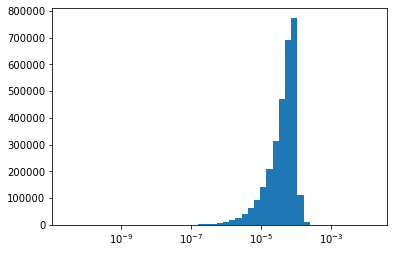

In [214]:
import numpy as np
abc = np.abs(next(model.parameters()).view(-1).cpu().detach().numpy())
print(np.min(abc),np.max(abc),np.mean(abc),np.median(abc))
import matplotlib.pyplot as plt
plt.hist(abc,bins=np.logspace(np.log10(np.min(abc)),np.log10(np.max(abc)), 50))
plt.gca().set_xscale("log")

In [238]:
next(model.parameters()).view((output_size),(input_size)).shape

torch.Size([140, 21491])

In [236]:
next(model.parameters()).shape

torch.Size([140, 21491])

(array([467., 269., 147.,  70.,  24.,   8.,   9.,   4.,   1.,   1.]),
 array([0.00313754, 0.00428089, 0.00542424, 0.00656759, 0.00771094,
        0.00885429, 0.00999764, 0.01114099, 0.01228434, 0.01342769,
        0.01457104], dtype=float32),
 <BarContainer object of 10 artists>)

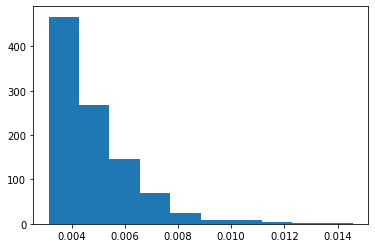

In [218]:
plt.hist(np.sort(abc)[::-1][:1000])

In [219]:
np.argmax(abc)

808117

In [225]:
len(abc)

3008740

In [239]:
np.argpartition(abc, -20)[-20:] % input_size

array([16483, 16842, 12938, 10006, 12936, 12940, 12950, 12950, 12939,
       12936, 16487, 16574, 16593, 12940, 16617, 12950, 16712, 16744,
       16806, 12950])

In [263]:
%pwd

'/home/jovyan/kaggle/working'

In [264]:
%cd sparse
np.savetxt('also_important.csv',also_important, delimiter=",")
%cd ..

/home/jovyan/kaggle/working/sparse
/home/jovyan/kaggle/working


In [261]:
also_important = np.argpartition(abc, -20)[-20:] % input_size

In [245]:
X_train_cite = np.hstack([X_train_cite,X_train[:,also_important].toarray()])

In [246]:
LR_START = 0.01
BATCH_SIZE = 256
reg1 = 8e-5
reg2 = 2e-5
model_cite = fit(X_train_cite,cite_targets,meta)

Epoch 1/1000
181/181 - 2s - loss: -7.9882e-01 - negative_correlation_loss: -8.2623e-01 - val_loss: -8.4306e-01 - val_negative_correlation_loss: -8.5945e-01 - lr: 0.0100 - 2s/epoch - 14ms/step
Epoch 2/1000
181/181 - 2s - loss: -8.7758e-01 - negative_correlation_loss: -8.9082e-01 - val_loss: -8.6447e-01 - val_negative_correlation_loss: -8.7549e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 3/1000
181/181 - 2s - loss: -8.8613e-01 - negative_correlation_loss: -8.9561e-01 - val_loss: -8.7339e-01 - val_negative_correlation_loss: -8.8212e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 4/1000
181/181 - 2s - loss: -8.8900e-01 - negative_correlation_loss: -8.9714e-01 - val_loss: -8.7323e-01 - val_negative_correlation_loss: -8.8085e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 5/1000
181/181 - 2s - loss: -8.9029e-01 - negative_correlation_loss: -8.9755e-01 - val_loss: -8.7381e-01 - val_negative_correlation_loss: -8.8048e-01 - lr: 0.0100 - 2s/epoch - 9ms/step
Epoch 6/1000
181/181 - 2s - loss: -8.9119e-0

In [251]:
%pwd

'/home/jovyan/kaggle/working'

In [252]:
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'
%mkdir dropout
%cd dropout
!kaggle kernels output sskknt/msci-citeseq-keras-quickstart-dropout
%cd ..

/home/jovyan/kaggle/working/dropout
Output file downloaded to /home/jovyan/kaggle/working/dropout/model.png
Output file downloaded to /home/jovyan/kaggle/working/dropout/submission.csv
Kernel log downloaded to /home/jovyan/kaggle/working/dropout/msci-citeseq-keras-quickstart-dropout.log 
/home/jovyan/kaggle/working


In [253]:
submission_dropout = np.genfromtxt("./dropout/submission.csv", delimiter=',')

In [ ]:
submission_dropout

In [356]:
LR_START = 0.01
BATCH_SIZE = 256

def my_model(hp,n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(hp.Int('units1', min_value=256, max_value=384, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    do1 = Dropout(hp.Choice('do1', [0.1]))(x0)
    x1 = Dense(hp.Int('units2', min_value=256, max_value=384, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(do1)
    do2 = Dropout(hp.Choice('do2', [0.1]))(x1)
    x2 = Dense(hp.Int('units3', min_value=256, max_value=384, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(do2)
    do3 = Dropout(hp.Choice('do3', [0.1]))(x2)
    x3 = Dense(hp.Int('units4', min_value=64, max_value=320, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(do3)
    do4 = Dropout(hp.Choice('do4', [0.1]))(x3)
    x = Concatenate()([x0, x1, x2, x3])
    do5 = Dropout(hp.Choice('do5', [0.1]))(x)
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(do5)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', min_value=0.008, max_value=0.012, step=0.001)),
                      metrics=[negative_correlation_loss],
                      loss=negative_correlation_loss
                     )
    
    return regressor

In [258]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.2 MB/s eta 0:00:00


In [292]:
import keras_tuner 
best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 0.000034,
                  'reg2': 1.000000e-10,
                  'units1': 256,
                  'units2': 512,
                  'units3': 512,
                  'units4': 64,
                  'do1': 0.1,
                  'do2': 0.1,
                  'do3': 0.1,
                  'do4': 0.1,
                  'do5': 0.1,
                  'lr': 0.007,
                 }

In [275]:
X_train_64 = np.genfromtxt("./pca64/X_train_64.csv", delimiter=',')
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
important = np.genfromtxt("./sparse/important_cols.csv", delimiter=',').astype(int)
also_important = np.genfromtxt("./sparse/also_important.csv", delimiter=',').astype(int)
important = np.concatenate([important,also_important])
X_train_cite = np.hstack([X_train_64,X_train[:,important].toarray()])

X_test_64 = np.genfromtxt("./pca64/X_test_64.csv", delimiter=',')
X_test = scipy.sparse.load_npz('./sparse/test_cite_inputs_values.sparse.npz')
X_test_cite = np.hstack([X_test_64,X_test[:,important].toarray()])

with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)

with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
meta_t = metadata_df.reindex(cell_index_t)

y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')

# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
y_train -= y_train.mean(axis=1).reshape(-1, 1)
y_train /= y_train.std(axis=1).reshape(-1, 1)

In [284]:
from tensorflow.keras.layers import Dropout

In [383]:


VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 6

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = KFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(best_hp, n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr
        if True:
            model.save(f"./model_multi/model_{fold}")

        history = history.history
        callbacks, lr = None, None

        # We validate the model
        y_va_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(y_va, y_va_pred)

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)
    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

In [361]:
%%time
from sklearn.model_selection import KFold
fit(X_train_cite,y_train,meta)

INFO:tensorflow:Assets written to: ./model/model_0/assets
1/1 [==============================] - 0s 97ms/step
Fold 0:  58 epochs, corr =  0.90057
INFO:tensorflow:Assets written to: ./model/model_1/assets
1/1 [==============================] - 0s 96ms/step
Fold 1:  52 epochs, corr =  0.90327
INFO:tensorflow:Assets written to: ./model/model_2/assets
1/1 [==============================] - 0s 96ms/step
Fold 2:  64 epochs, corr =  0.90146
INFO:tensorflow:Assets written to: ./model/model_3/assets
1/1 [==============================] - 0s 95ms/step
Fold 3:  49 epochs, corr =  0.90327
INFO:tensorflow:Assets written to: ./model/model_4/assets
1/1 [==============================] - 0s 102ms/step
Fold 4:  58 epochs, corr =  0.90719
INFO:tensorflow:Assets written to: ./model/model_5/assets
1/1 [==============================] - 0s 104ms/step
Fold 5:  68 epochs, corr =  0.88467
Average  corr = 0.90007
CPU times: user 1h 34min 10s, sys: 19min 47s, total: 1h 53min 57s
Wall time: 15min 50s


In [301]:
fit(X_train_cite,y_train,meta)

Epoch 1/1000
45/45 - 2s - loss: -7.6535e-01 - negative_correlation_loss: -7.9414e-01 - val_loss: -8.1621e-01 - val_negative_correlation_loss: -8.3852e-01 - lr: 0.0070 - 2s/epoch - 42ms/step
Epoch 2/1000
45/45 - 1s - loss: -8.4737e-01 - negative_correlation_loss: -8.6687e-01 - val_loss: -8.5308e-01 - val_negative_correlation_loss: -8.6854e-01 - lr: 0.0070 - 952ms/epoch - 21ms/step
Epoch 3/1000
45/45 - 1s - loss: -8.7593e-01 - negative_correlation_loss: -8.8999e-01 - val_loss: -8.6761e-01 - val_negative_correlation_loss: -8.7898e-01 - lr: 0.0070 - 945ms/epoch - 21ms/step
Epoch 4/1000
45/45 - 1s - loss: -8.8443e-01 - negative_correlation_loss: -8.9510e-01 - val_loss: -8.7420e-01 - val_negative_correlation_loss: -8.8302e-01 - lr: 0.0070 - 937ms/epoch - 21ms/step
Epoch 5/1000
45/45 - 1s - loss: -8.8917e-01 - negative_correlation_loss: -8.9765e-01 - val_loss: -8.7445e-01 - val_negative_correlation_loss: -8.8164e-01 - lr: 0.0070 - 940ms/epoch - 21ms/step
Epoch 6/1000
45/45 - 1s - loss: -8.911

In [350]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        abc =  tf.cond(step < 20,
            true_fn=lambda: self.initial_learning_rate,
            false_fn=lambda: tf.cond(step < 25,
                true_fn=lambda: self.initial_learning_rate/2,
                false_fn=lambda: tf.cond(step < 31,    
                    true_fn=lambda: self.initial_learning_rate/4,
                    false_fn=lambda: tf.cond(step < 31,
                        true_fn=lambda: self.initial_learning_rate/8,
                        false_fn=lambda: self.initial_learning_rate/16))))
        return abc
        
BATCH_SIZE = 256

def my_model(hp,n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(hp.Int('units1', min_value=256, max_value=384, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    do1 = Dropout(hp.Choice('do1', [0.1]))(x0)
    x1 = Dense(hp.Int('units2', min_value=256, max_value=384, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(do1)
    do2 = Dropout(hp.Choice('do2', [0.1]))(x1)
    x2 = Dense(hp.Int('units3', min_value=256, max_value=384, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(do2)
    do3 = Dropout(hp.Choice('do3', [0.1]))(x2)
    x3 = Dense(hp.Int('units4', min_value=64, max_value=320, step=64), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(do3)
    do4 = Dropout(hp.Choice('do4', [0.1]))(x3)
    x = Concatenate()([x0, x1, x2, x3])
    do5 = Dropout(hp.Choice('do5', [0.1]))(x)
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(do5)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=MyLRSchedule(0.007)),
                      metrics=[negative_correlation_loss],
                      loss=negative_correlation_loss
                     )
    
    return regressor

In [344]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or "learning_rate" in logs:
            return
        logs["learning_rate"] = self.model.optimizer.lr

In [351]:
def refit(X_train, y_train,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = None
    gc.collect()

    es = EarlyStopping(monitor="val_loss",
                      patience=12, 
                      verbose=0,
                      mode="min", 
                      restore_best_weights=True)
    callbacks = [es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(best_hp, n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    del X_tr, y_tr

    history = history.history
    callbacks, lr = None, None

    return model

model = refit(X_train_cite,y_train)

Epoch 1/1000
278/278 - 4s - loss: -8.1010e-01 - negative_correlation_loss: -8.3295e-01 - 4s/epoch - 13ms/step
Epoch 2/1000
278/278 - 3s - loss: -8.6256e-01 - negative_correlation_loss: -8.7780e-01 - 3s/epoch - 10ms/step
Epoch 3/1000


KeyboardInterrupt: 

In [362]:
%ls catboost

catboost_info/                              model02.pkl  pca.pkl
lb-t15-msci-multiome-catboostregressor.log  model03.pkl  preds.npy
model00.pkl                                 model04.pkl  submission.csv
model01.pkl                                 pca2.pkl


In [395]:
abc = model.predict(multi_X_test)

1748/1748 [==============================] - 5s 3ms/step


In [396]:
abc.shape

(55935, 128)

In [420]:
len(test_cite_pred.ravel())

6812820

In [421]:
len(submission) - len(test_cite_pred.ravel())

58931360

In [423]:
abc.shape

(55935, 23418)

In [425]:
temp = pd.read_parquet('./sparse/evaluation.parquet')

In [430]:
temp.groupby('cell_id').count().value_counts()

row_id  gene_id
140     140        48663
3512    3512       16780
dtype: int64

In [422]:
len(multi_X_test)

55935

In [431]:
len(X_test_cite)

48663

In [432]:
%%time
# Read the table of rows and columns required for submission
eval_ids = pd.read_parquet("./sparse/evaluation.parquet")
# Convert the string columns to more efficient categorical types
#eval_ids.cell_id = eval_ids.cell_id.apply(lambda s: int(s, base=16))
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

CPU times: user 19.5 s, sys: 4.23 s, total: 23.8 s
Wall time: 19.6 s


In [434]:
submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)
submission


MultiIndex([(       0, 'c2150f55becb',            'CD86'),
            (       1, 'c2150f55becb',           'CD274'),
            (       2, 'c2150f55becb',           'CD270'),
            (       3, 'c2150f55becb',           'CD155'),
            (       4, 'c2150f55becb',           'CD112'),
            (       5, 'c2150f55becb',            'CD47'),
            (       6, 'c2150f55becb',            'CD48'),
            (       7, 'c2150f55becb',            'CD40'),
            (       8, 'c2150f55becb',           'CD154'),
            (       9, 'c2150f55becb',            'CD52'),
            ...
            (65744170, '2c53aa67933d', 'ENSG00000275549'),
            (65744171, '2c53aa67933d', 'ENSG00000233643'),
            (65744172, '2c53aa67933d', 'ENSG00000280213'),
            (65744173, '2c53aa67933d', 'ENSG00000239467'),
            (65744174, '2c53aa67933d', 'ENSG00000224812'),
            (65744175, '2c53aa67933d', 'ENSG00000134419'),
            (65744176, '2c53aa67933d', '

In [435]:
y_columns = np.load("./sparse/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]

test_index = np.load("./sparse/test_multi_inputs_idxcol.npz",
                    allow_pickle=True)["index"]

In [438]:
cell_dict = dict((k,v) for v,k in enumerate(test_index)) 
assert len(cell_dict)  == len(test_index)

gene_dict = dict((k,v) for v,k in enumerate(y_columns))
assert len(gene_dict) == len(y_columns)

In [440]:
eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))

valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)

In [444]:
abc.shape

(55935, 23418)

In [445]:
submission.iloc[valid_multi_rows] = abc[eval_ids_cell_num[valid_multi_rows].to_numpy(),
eval_ids_gene_num[valid_multi_rows].to_numpy()]

In [447]:
submission

row_id    cell_id       gene_id        
0         c2150f55becb  CD86                    NaN
1         c2150f55becb  CD274                   NaN
2         c2150f55becb  CD270                   NaN
3         c2150f55becb  CD155                   NaN
4         c2150f55becb  CD112                   NaN
                                             ...   
65744175  2c53aa67933d  ENSG00000134419    5.159278
65744176  2c53aa67933d  ENSG00000186862   -0.710506
65744177  2c53aa67933d  ENSG00000170959   -0.562515
65744178  2c53aa67933d  ENSG00000107874    0.522227
65744179  2c53aa67933d  ENSG00000166012    5.658827
Name: target, Length: 65744180, dtype: float32

In [448]:
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'

In [449]:
submission.iloc[:len(test_cite_pred.ravel())] = test_cite_pred.ravel()

In [450]:
submission

row_id
0          -14.205769
1          -13.714285
2          -11.913100
3           10.173475
4           16.069633
              ...    
65744175     5.159278
65744176    -0.710506
65744177    -0.562515
65744178     0.522227
65744179     5.658827
Name: target, Length: 65744180, dtype: float32

In [453]:
assert not submission.isna().any()

In [415]:
if True:
    # test_cite_pred = np.zeros((len(X_test_cite), 140), dtype=np.float32)
    # for fold in range(6):
    #     print(f"Predicting with fold {fold}")
    #     model = load_model(f"./model/model_{fold}",
    #                        custom_objects={'negative_correlation_loss': negative_correlation_loss})
    #     test_cite_pred += model.predict(X_test_cite)/6
    
    # Copy the targets for the data leak
    #test_pred[:7476] = Y[:7476]
    test_multi_pred = np.zeros((len(multi_X_test), 22858), dtype=np.float32)
    for fold in range(3):
        print(f"Predicting with fold {fold}")
        model = load_model(f"./model_multi/model_{fold}",
                           custom_objects={'negative_correlation_loss': negative_correlation_loss})
        test_multi_pred += pca_train.inverse_transform(model.predict(multi_X_test))/3
    abc = np.zeros((len(multi_X_test), 22858 + len(zero_columns)), dtype=np.float32)
    j = 0
    for i in range(22858 + len(zero_columns)):
        if i in zero_columns:
            pass
        else:
            abc[:,i] = test_multi_pred[:,j]
            j += 1

    #with open("../input/msci-multiome-quickstart/partial_submission_multi.pickle", 'rb') as f: submission = pickle.load(f)
    #submission = pd.read_csv('./catboost/submission.csv',
    #                         index_col='row_id', squeeze=True)
    submission.iloc[:len(test_cite_pred.ravel())] = test_cite_pred.ravel()
    submission.iloc[len(test_cite_pred.ravel()):] = abc.ravel()
    assert not submission.isna().any()
    submission.to_csv('submission.csv')
    display(submission)

Predicting with fold 0
1748/1748 [==============================] - 5s 3ms/step
Predicting with fold 1
1748/1748 [==============================] - 5s 3ms/step
Predicting with fold 2
1748/1748 [==============================] - 5s 3ms/step


ValueError: cannot set using a slice indexer with a different length than the value

In [366]:
pca_train.inverse_transform(model.predict(multi_X_test))

2219/2219 [==============================] - 6s 3ms/step


array([[-13.601508 , -12.951623 , -11.266804 , ..., -12.711218 ,
         -4.7161765,  -5.734308 ],
       [-13.768899 , -13.870382 , -12.165372 , ..., -13.139913 ,
         -1.6309749,  -6.3214684],
       [-11.332975 ,  -9.842586 ,  -8.402178 , ..., -11.158837 ,
         18.831457 ,  -2.2068696],
       ...,
       [-16.312664 , -14.1682005, -10.3791895, ..., -14.877346 ,
         25.273022 ,   5.3378005],
       [-11.829328 , -10.988879 ,  -8.950435 , ...,  -9.898064 ,
          4.602272 ,   2.5388331],
       [ -9.037295 ,  -8.111307 ,  -6.421322 , ...,  -8.424071 ,
         13.414315 ,   3.318079 ]], dtype=float32)

In [367]:
y_train

matrix([[ 0.09460447, -0.16236247, -0.40533194, ..., -0.2604974 ,
          0.38325763, -0.19745262],
        [-0.25125083, -0.35797054, -0.16268902, ..., -0.19555242,
          0.40262994,  0.21424626],
        [-0.5045346 , -0.52717906, -0.6661142 , ..., -0.78993785,
          0.9858621 ,  0.6095203 ],
        ...,
        [-0.21439946, -0.42171356, -0.15420535, ..., -0.28104922,
          1.3694407 ,  0.39634088],
        [-0.59204555, -0.8529565 , -0.36310583, ..., -0.15817975,
          0.16098164,  0.7527571 ],
        [-0.64900035, -0.6185921 , -0.27466986, ..., -0.3303311 ,
          1.6578442 ,  0.4573473 ]], dtype=float32)

In [368]:
correlation_score(y_train,model.predict(X_train_cite))

2219/2219 [==============================] - 6s 3ms/step


0.9059421959098458

In [369]:
%pwd

'/home/jovyan/kaggle/working'

In [455]:
submission.to_csv("submission.csv")

In [456]:
!kaggle competitions submit -c open-problems-multimodal -f submission.csv -m 'third submit'

100%|██████████████████████████████████████| 1.20G/1.20G [04:32<00:00, 4.74MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [387]:
pca_train = TruncatedSVD(n_components=140, random_state=1)
pca_cite_targets = pca_train.fit_transform(y_train)
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 6

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = KFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(best_hp, n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr
        if True:
            model.save(f"./model_multi/model_{fold}")

        history = history.history
        callbacks, lr = None, None

        # We validate the model
        y_va_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(pca_train.inverse_transform(y_va), pca_train.inverse_transform(y_va_pred))

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)
    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
fit(X_train_cite,pca_cite_targets,meta)

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


INFO:tensorflow:Assets written to: ./model_multi/model_0/assets
1/1 [==============================] - 0s 105ms/step
Fold 0:  47 epochs, corr =  0.87441
INFO:tensorflow:Assets written to: ./model_multi/model_1/assets
1/1 [==============================] - 0s 98ms/step
Fold 1:  70 epochs, corr =  0.87610
INFO:tensorflow:Assets written to: ./model_multi/model_2/assets
1/1 [==============================] - 0s 97ms/step
Fold 2:  57 epochs, corr =  0.87552


KeyboardInterrupt: 

In [401]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")

In [402]:
targets.shape

(105942, 23418)

In [407]:
means = targets.mean(axis=0)

In [414]:
zero_columns = (np.where(means == 0.0)[1])

In [412]:
22858 - 23418

-560

In [403]:
targets2 = scprep.filter.remove_empty_genes(targets)
targets2.shape

(105942, 22858)

In [388]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=128, random_state=1)
pca_targets = pca_train.fit_transform(targets)

VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, pca_y_train,y_train, meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train,groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = pca_y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = pca_y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(best_hp, n_inputs=X_train.shape[1],n_outputs=pca_y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr
        if True:
            model.save(f"./model_multi/model_{fold}")

        history = history.history
        callbacks, lr = None, None

        # We validate the model
        y_va_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(y_train, pca_train.inverse_transform(y_va_pred))

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)
    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']

with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)    
    
model = fit(multi_X_train,pca_targets,meta)

/srv/conda/envs/saturn/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


INFO:tensorflow:Assets written to: ./model_multi/model_0/assets
1/1 [==============================] - 0s 124ms/step
Fold 0:  61 epochs, corr =  0.74081
INFO:tensorflow:Assets written to: ./model_multi/model_1/assets
1/1 [==============================] - 0s 121ms/step
Fold 1:  70 epochs, corr =  0.80201
INFO:tensorflow:Assets written to: ./model_multi/model_2/assets
1/1 [==============================] - 0s 125ms/step
Fold 2:  51 epochs, corr =  0.73724
Average  corr = 0.76002


In [400]:
pca_train.inverse_transform(model.predict(multi_X_test))

1748/1748 [==============================] - 5s 3ms/step


array([[-0.6032392 , -0.18927236, -1.8514775 , ..., -0.25472936,
        -1.4116759 ,  4.825427  ],
       [-0.504821  , -0.13165976, -1.2397938 , ...,  0.06415745,
        -0.95780236,  3.5212119 ],
       [-0.5903374 , -0.15724015, -1.3592209 , ..., -0.03801346,
        -1.5233644 ,  4.589586  ],
       ...,
       [-0.9454026 , -0.1630902 , -1.1969365 , ...,  0.07594557,
        -1.6332266 ,  4.6637654 ],
       [-0.95335853, -0.08189125, -1.2614698 , ...,  0.23453274,
        -1.4778428 ,  5.4175267 ],
       [-0.5581044 ,  0.24563164, -1.9429853 , ...,  0.37694648,
         1.8613381 ,  6.9312553 ]], dtype=float32)

In [ ]:
targets

In [ ]:
targets = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

pca_train = TruncatedSVD(n_components=512, random_state=1)
pca_targets = pca_train.fit_transform(targets)

VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, y_train, meta, loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train,groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(best_hp, n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr
        if True:
            model.save(f"./model_multi/model_{fold}")

        history = history.history
        callbacks, lr = None, None

        # We validate the model
        y_va_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(pca_train.inverse_transform(y_va), pca_train.inverse_transform(y_va_pred))

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)
    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']

with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)    
    
model = fit(multi_X_train,pca_targets,meta)